In [1]:
from model import GPT, GPTConfig
import torch
import numpy as np
from torch.nn import functional as F
from Qiskit.Circuit_generate import circuit_generator, get_tr_dist_matrix, get_fid_matrix, calculate_fidelity
from dataload import get_data
from torch.utils.data import DataLoader, TensorDataset
from qiskit.circuit.library import ZZFeatureMap
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
import matplotlib.pyplot as plt

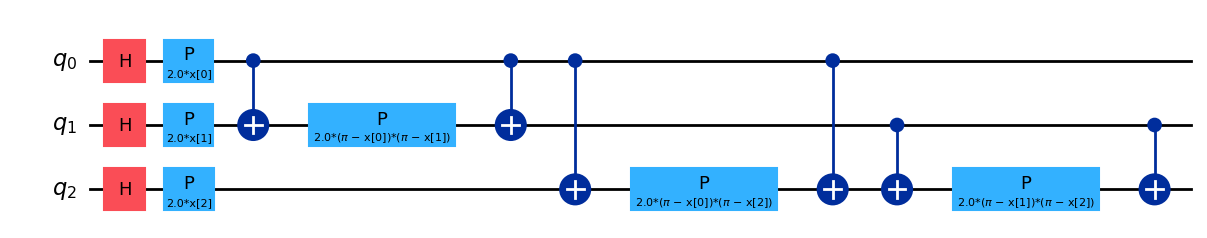

In [2]:
from qiskit.circuit.library import ZZFeatureMap
prep = ZZFeatureMap(3, reps=1)
prep.decompose().draw('mpl')

In [3]:
X_train, y_train = get_data(name='iris')

n,p = X_train.shape

"""If use qubit matching, set num_qubits = p  otherwise, it is up to user's choice"""
num_qubits = 1
op_pool_size = p*7*num_qubits
max_gate = 10           # senario legth

ValueError: too many values to unpack (expected 2)

In [ ]:
class GPTQE(GPT):
    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        return logits

    def calculate_loss(self, tokens, fidelity):
        # 현재 토큰 시퀀스와 다음 토큰 시퀀스를 분리
        fidelity = 1 - fidelity
        tokens = tokens.reshape(1,-1)
        current_tokens, next_tokens = tokens[:, :-1], tokens[:, 1:]
    
        # 현재 토큰 시퀀스에 대한 예측 로짓 계산
        logits = self(current_tokens)
    
        # 실제 다음 토큰에 해당하는 로짓 선택
        next_token_mask = torch.nn.functional.one_hot(
            next_tokens, num_classes=self.config.vocab_size
        )

        next_token_logits = (logits * next_token_mask).sum(axis=2)
        # 각 시퀀스에 대한 누적 로짓 계산
        cumsum_logits = torch.sum(next_token_logits)
    
        # 누적 로짓과 Fidelity 간의 차이를 제곱해 평균 손실로 계산
        loss = torch.mean(torch.square(cumsum_logits - fidelity))
    
        return loss


    @torch.no_grad()
    def generate(self, n_sequences, max_new_tokens, temperature=1., device="cpu"):
        idx = torch.zeros(size=(n_sequences, 1), dtype=int, device=device)
        total_logits = torch.zeros(size=(n_sequences, 1), device=device)
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits = self(idx_cond)
            # pluck the logits at the final step
            logits = logits[:, -1, :]
            # set the logit of the first token so that its probability will be zero
            logits[:, 0] = -float("inf")
            # apply softmax to convert logits to (normalized) probabilities and scale by desired temperature
            probs = F.softmax(logits / temperature, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # # Accumulate logits
            total_logits += torch.gather(logits, index=idx_next, dim=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, total_logits


In [24]:
gpt = GPTQE(GPTConfig(
    vocab_size=op_pool_size + 1,
    block_size=max_gate,
    dropout=0.2,
    n_layer = 12,
    n_head = 12,
    n_embd=768,
    bias=False
)).to("cuda")

### Hyperparameter setting
opt = gpt.configure_optimizers(
    weight_decay=0.01, learning_rate=5e-5, betas=(0.9, 0.999), device_type="cuda"
)

num_iterations = 1000       # 총 학습 반복 횟수

number of parameters: 85.04M
num decayed parameter tensors: 50, with 85,029,120 parameters
num non-decayed parameter tensors: 25, with 19,200 parameters
using fused AdamW: True


In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# TensorDataset을 사용하여 데이터셋 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# DataLoader로 배치 단위로 데이터 로드
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

loss_record = []
fidloss_record = []
for iteration in range(num_iterations):
    # 1. token generating
    epsilon = (num_iterations - iteration) / num_iterations
    tokens, logits = gpt.generate(n_sequences=1,temperature=1/epsilon, max_new_tokens=max_gate, device="cuda") 
    tokens = tokens.reshape(-1,1)
    loss_mini = []
    fid_mini = []
    for x_batch, y_batch in train_loader:
        # 2. embbeding
        quantum_states = []
        for x in x_batch:
            circuit, state = circuit_generator(tokens, n_qubits=num_qubits, data=x, matching=False) 
            quantum_states.append(state)
    
        # 3. Fidelity loss
        fid_mat = get_fid_matrix(quantum_states)
        fidloss = calculate_fidelity(fid_mat, y_batch)  
    
        # 4. optimizing
        opt.zero_grad()
        loss = gpt.calculate_loss(tokens, fidloss)
        loss.backward()
        opt.step()

        loss_mini.append(loss.item())
        fid_mini.append(fidloss)
    
    loss_record.append(torch.mean(torch.tensor(loss_mini)))
    fidloss_record.append(torch.mean(torch.tensor(fid_mini)))

    # 5. learning process
    if (iteration + 1) % 1 == 0:
        gpt.eval()
        ev_tokens, _ = gpt.generate(n_sequences=1, max_new_tokens=max_gate, temperature=0.001,device="cuda")
        ev_tokens = ev_tokens.reshape(-1,1)
        ev_states_lst = []

        for x_ev in X_train:
            ev_circuit, ev_state = circuit_generator(ev_tokens, n_qubits=num_qubits, data=x_ev, matching=False) 
            ev_states_lst.append(ev_state)
        
        ev_fid_mat = get_fid_matrix(ev_states_lst)
        ev_fidloss = calculate_fidelity(ev_fid_mat, y_train)
        ev_loss = gpt.calculate_loss(ev_tokens, ev_fidloss)
        gpt.train()
        print(f"Iteration [{iteration + 1}/{num_iterations}], Loss: {ev_loss}, Fidelity loss: {ev_fidloss}")

Iteration [1/10000], Loss: 356.9369201660156, Fidelity loss: 0.5050505050505051
Iteration [2/10000], Loss: 283.6143798828125, Fidelity loss: 0.5050505050505051
Iteration [3/10000], Loss: 358.5869445800781, Fidelity loss: 0.39666865645669497


KeyboardInterrupt: 

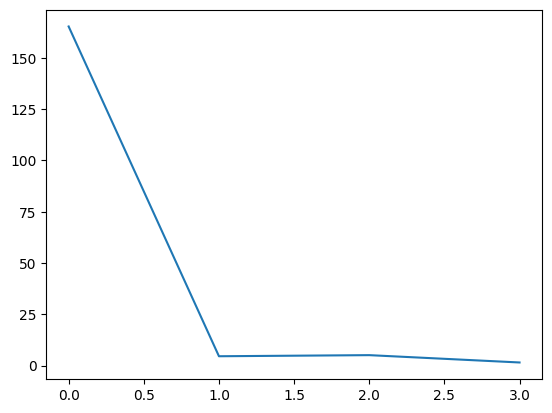

In [26]:
plt.plot(loss_record)

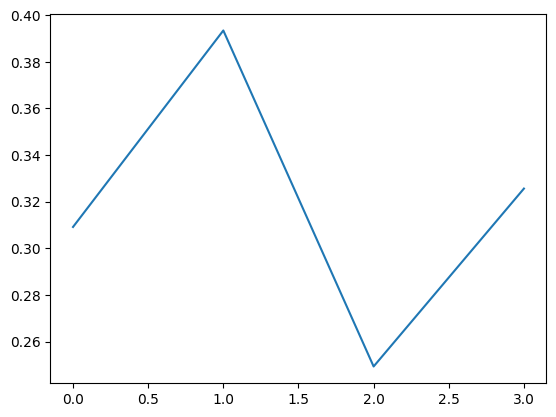

In [27]:
plt.plot(fidloss_record)

In [15]:
logits.shape

torch.Size([1, 10, 113])

In [19]:
1/np.inf

0.0

In [19]:
cumsum_logits = torch.cumsum(next_token_logits, dim=1)
cumsum_logits.shape

torch.Size([1, 10])

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=p, reps=2, entanglement='linear')

X_train_zz, y_train_zz = get_data(name='iris', zzmapping=True)


# Process each sample
zz_quantum_circuits = []
zz_states = []
for sample in X_train_zz:
    # Create a mapping from parameters to sample values
    param_dict = dict(zip(feature_map.parameters, sample))
    # Assign the sample features to the circuit parameters
    bound_circuit = feature_map.assign_parameters(param_dict)
    zz_quantum_circuits.append(bound_circuit)
    states = Statevector.from_instruction(bound_circuit)
    zz_states.append(states)

zz_fidmat = get_fid_matrix(zz_states)
zz_fidloss = calculate_fidelity(zz_fidmat, y_train_zz)

In [5]:
zz_fidloss

np.float64(0.46855961444790806)

In [6]:
bound_circuit.draw()

┌────────────────────────────────────────┐
q_0: ┤0                                       ├
     │                                        │
q_1: ┤1                                       ├
     │  ZZFeatureMap(1.629,π/3,2.3754,2.2176) │
q_2: ┤2                                       ├
     │                                        │
q_3: ┤3                                       ├
     └────────────────────────────────────────┘